### Lets create an generator for our recontruction with LSST background

In [5]:
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM
import numpy as np

from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian
from lenstronomy.SimulationAPI.sim_api import SimAPI
import matplotlib.pyplot as plt
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Data.pixel_grid import PixelGrid

In [6]:
z_lens, z_source = 0.881, 2.059
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

In [ ]:
# The three visible bands in LSST
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)

lsst_bands = [LSST_g, LSST_r, LSST_i]

# === Paso 1: Definir tamaño del campo de visión e imagen ===
size = 6.0         # en arcsec
numpix = 4        # número total de píxeles
pixel_scale = size / numpix  # 0.09375 arcsec/pix

# # === Paso 2: Crear nuevamente las bandas con pixel_scale correcto ===

# def make_lsst_band(band_name):
#     band = LSST(band=band_name, psf_type='GAUSSIAN', coadd_years=10)
#     # Forzar pixel scale a resolución deseada
#     band.kwargs_single_band()['pixel_scale'] = pixel_scale
#     return band

# LSST_g = make_lsst_band('g')
# LSST_r = make_lsst_band('r')
# LSST_i = make_lsst_band('i')

# lsst_bands = [LSST_g, LSST_r, LSST_i]

In [8]:
pixel_scale

0.15

Then, define the lens model

In [9]:
#We need two models: one noisy with a subhalo and one smooth without a subhalo.
#lets start with the noisy model

#model list and kwargs for the lens

#for the source light model, we use a Sersic profile
#for the lens model, we use an elliptical power-law (EPL) profile, a singular isothermal sphere (SIS), and a reduced shear model

lens_model_list = ['EPL', 'SIS', 'SHEAR_REDUCED']  # with subhalo
### kwargs for the subhalo lens models

##subhalo parameters, for an isothermal sphere (SIS) profile
mass_subhalo = 1e9  # Mass of the subhalo in solar masses
position_subhalo = [1.0,1.0]  # Position of the subhalo in arcseconds

M_sub = mass_subhalo * u.M_sun  # Masa del subhalo
# Cálculo del radio de Einstein del subhalo en radianes
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
# Conversión del radio de Einstein a arcosegundos
thetaE_sub = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E': thetaE_sub, 
'center_x': position_subhalo[0], 
'center_y': position_subhalo[1]} 

##kwargs for the main lens model

#Einstein radius and the gamma and gamma
theta_E_main, gamma_main = 1.452, 1.9
e1_main, e2_main = phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)  # Elipticidad de la lente principal
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x': 0.0, 'center_y': -0.1  # Centro de la lente principal
} 

## shear reduced parameters
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)  # Conversión de cizalla polar a cartesiana
kwargs_shear = {'gamma1': g1, 'gamma2': g2}

# Combine all kwargs into a list
kwargs_lens = [kwargs_main, kwargs_sub, kwargs_shear]

In [10]:
thetaE_sub

0.046788421330938676

In [11]:
#Now the smooth model without the subhalo
lens_model_list_nosub = ['EPL', 'SHEAR_REDUCED']  # Sin el subhalo
kwargs_lens_nosub = [kwargs_main, kwargs_shear]

#kwargs for the main lens model without subhalo
kwargs_model_sub = {
    'lens_model_list': lens_model_list,
    'source_light_model_list': ['SERSIC'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

#kwargs for the main lens model without subhalo
kwargs_model_nosub= {
    'lens_model_list': lens_model_list_nosub,
    'source_light_model_list': ['SERSIC'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

In [12]:
#light source model parameters

# Colores por banda
mag_g = 22.0
g_r = 1.0
g_i = 2.0
R_sersic = 0.15  # Radio de Sersic en arcosegundos
n_sersic = 1.0  # Índice de Sersic

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': R_sersic, 'n_sersic': n_sersic,
                        'center_x': 0.0, 'center_y': 0.0}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

source_mags = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]

In [13]:
def simulate_rgb_image(
    band_configs,
    model_config,
    kwargs_lens,
    kwargs_source_mags,
    size=6.0,
    kwargs_numerics=None,
    add_noise=True
):
    """
    Simula imagen RGB con múltiples bandas usando sólo fuente extendida (Sersic).
    Sin luz de lente ni fuentes puntuales.
    """
    images = []

    for band_config, kwargs_source_mag in zip(band_configs, kwargs_source_mags):
        kw_band = band_config.kwargs_single_band()
        #pixel_scale = kw_band['pixel_scale']
        pixel_scale = 0.15
        numpix = int(round(size / pixel_scale))

        # Inicializar simulador
        sim = SimAPI(numpix=numpix, kwargs_single_band=kw_band, kwargs_model=model_config)
        _, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])
        imSim = sim.image_model_class(kwargs_numerics)

        # Simulación de imagen
        image = imSim.image(kwargs_lens, kwargs_source, None, None)
        if add_noise:
            image += sim.noise_for_model(model=image)

        images.append(image)

    return np.stack(images, axis=-1)


In [14]:
# Configuraciones numéricas
kwargs_numerics = {'point_source_supersampling_factor': 1}

# Imagen limpia (sin subhalo, sin ruido)
img_clean = simulate_rgb_image(
    band_configs=lsst_bands,
    model_config=kwargs_model_nosub,
    kwargs_lens=[kwargs_main, kwargs_shear],
    kwargs_source_mags=source_mags,
    size=6.0,
    kwargs_numerics=kwargs_numerics,
    add_noise=False
)

# Imagen con subhalo + ruido
img_subhalo = simulate_rgb_image(
    band_configs=lsst_bands,
    model_config=kwargs_model_sub,
    kwargs_lens=[kwargs_main, kwargs_sub, kwargs_shear],
    kwargs_source_mags=source_mags,
    size=6.0,
    kwargs_numerics=kwargs_numerics,
    add_noise=True
)


In [15]:
def scale_image_rgb(img):  # img shape: (N, N, 3)
    def _scale_max(image): 
        flat = image.flatten()
        flat.sort()
        return flat[int(len(flat)*0.95)]
    img_scaled = np.zeros_like(img)
    for i in range(3):
        img_scaled[..., i] = plot_util.sqrt(img[..., i], scale_min=0, scale_max=_scale_max(img[..., i]))
    return img_scaled

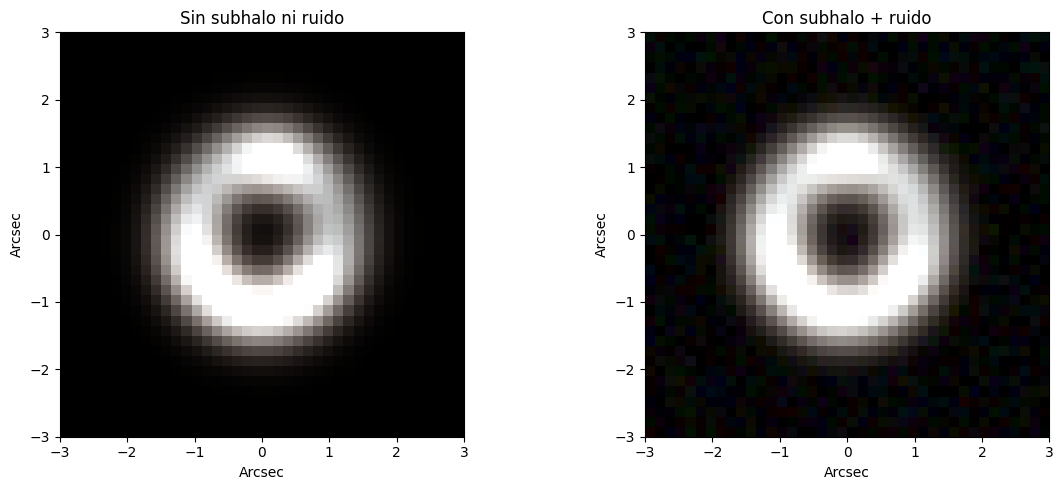

In [20]:
#size=.0
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(scale_image_rgb(img_clean), origin='lower', extent=[-size/2, size/2, -size/2, size/2])
axes[0].set_title("Sin subhalo ni ruido")
axes[0].set_xlabel("Arcsec")
axes[0].set_ylabel("Arcsec")

axes[1].imshow(scale_image_rgb(img_subhalo), origin='lower', extent=[-size/2, size/2, -size/2, size/2])
axes[1].set_title("Con subhalo + ruido")
axes[1].set_xlabel("Arcsec")
axes[1].set_ylabel("Arcsec")

plt.tight_layout()
plt.show()


In [17]:
print("img_clean shape:", img_clean.shape)
print("img_subhalo shape:", img_subhalo.shape)

img_clean shape: (40, 40, 3)
img_subhalo shape: (40, 40, 3)


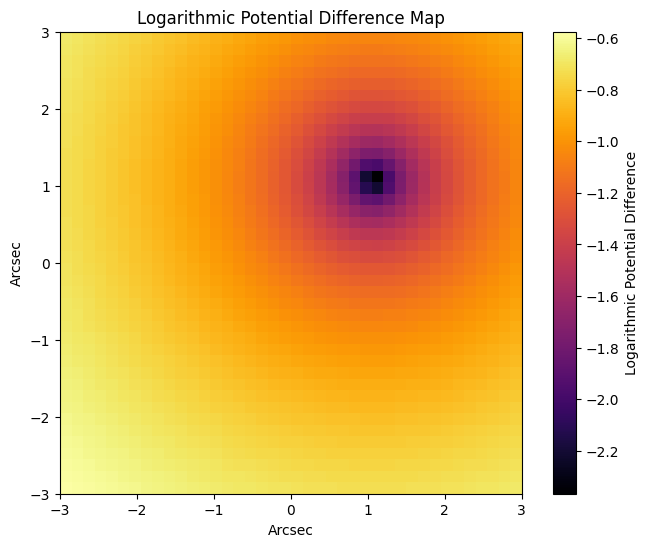

In [18]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Util.param_util import shear_polar2cartesian
# from lenstronomy.Util.pixel_grid import PixelGrid

from lenstronomy.Util import util

from lenstronomy.LensModel.lens_model import LensModel
import matplotlib.pyplot as plt
import numpy as np

# # # 1. Parámetros consistentes con imagen RGB
# numpix = 40
# size = 6.0  # arcsec (campo de visión total)
# pixel_scale = size / numpix  # → 0.09375 arcsec/pixel

size = pixel_scale * numpix  # Esto asegura que se ajusta a la imagen actual
extent = [-size/2, size/2, -size/2, size/2]

# 2. Grid físico (centrado)
ra_at_xy_0 = -size / 2
dec_at_xy_0 = -size / 2
transform_pix2angle = np.eye(2) * pixel_scale

kwargs_pixel = {
    'nx': numpix,
    'ny': numpix,
    'ra_at_xy_0': ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle
}

pixel_grid = PixelGrid(**kwargs_pixel)
x_coords, y_coords = pixel_grid.pixel_coordinates
x_flat, y_flat = x_coords.flatten(), y_coords.flatten()

# 3. Modelos de lente con y sin subhalo
lensModel = LensModel(lens_model_list=kwargs_model_sub['lens_model_list'])
lensModel_nosub = LensModel(lens_model_list=kwargs_model_nosub['lens_model_list'])

# 4. Potenciales y diferencia
psi_sub = lensModel.potential(x_flat, y_flat, kwargs_lens).reshape(x_coords.shape)
psi_nosub = lensModel_nosub.potential(x_flat, y_flat, kwargs_lens_nosub).reshape(x_coords.shape)
delta_psi_map = psi_sub - psi_nosub

# 5. Escala logarítmica
epsilon = 1e-3
delta_psi_log = np.log10(np.abs(delta_psi_map) + epsilon) * np.sign(delta_psi_map)

# 6. Visualización
plt.figure(figsize=(8, 6))
plt.imshow(delta_psi_log, origin='lower', extent=[-size/2, size/2, -size/2, size/2], cmap='inferno')
plt.colorbar(label='Logarithmic Potential Difference')
plt.title('Logarithmic Potential Difference Map')
plt.xlabel('Arcsec')
plt.ylabel('Arcsec')
plt.show()



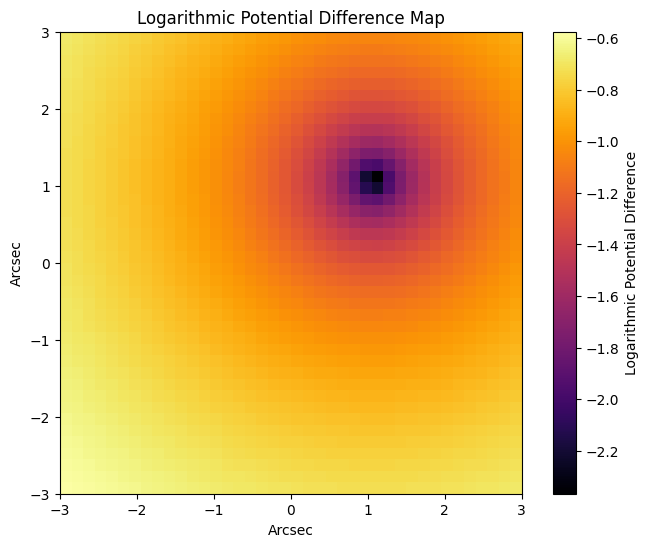

In [19]:
# Example usage
plt.figure(figsize=(8, 6))
plt.imshow(delta_psi_log, origin='lower', extent=[-size/2, size/2, -size/2, size/2], cmap='inferno')
plt.colorbar(label='Logarithmic Potential Difference')
plt.title('Logarithmic Potential Difference Map')
plt.xlabel('Arcsec')
plt.ylabel('Arcsec')
plt.show()